# BIKE LENDING 
### This assignment is a programming assignment wherein  a linear regression model for the prediction of demand for shared bikes is built. 

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [78]:
df=pd.read_csv(filepath_or_buffer=r'D:\ML&AI\day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [79]:
df.shape

(730, 16)

There are 730 data points and there are 16 columns. The variables mean the following:
- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not 
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
The variable ( column) cnt is the total number of bikes that are rented. Since we want to predict this variable, it is the target variable.

## Data Manipulation
### Converting categorical variables such as season, yr, mnth, holiday, weekday, weathersit to their respective variable 
This is done for better understanding during EDA

In [80]:
def season(x):
    if x==1:
        return 'spring'
    elif x==2:
        return 'summer'
    elif x==3:
        return 'fall'
    else:
        return 'winter'
def year(x):
    if x==0:
        return 2018
    else:
        return 2019
def holiday(x):
    if x==0:
        return 'Not a Holiday'
    else:
        return 'Holiday'
def weathersit(x):
    if x==1:
        return 'Clear'
    elif x==2:
        return 'Misty'
    elif x==3:
        return 'Snowy'
    else:
        return 'Rainy'
def weekday(x):
    if x==0:
        return 'Sunday'
    elif x==1:
        return 'Monday'
    elif x==2:
        return 'Tuesday'
    elif x==3:
        return 'Wednesday'
    elif x==4:
        return 'Thursday'
    elif x==5:
        return 'Friday'
    else:
        return 'Saturday'
def mnth(x):
    if x==1:
        return 'Jan'
    elif x==2:
        return 'Feb'
    elif x==3:
        return 'Mar'
    elif x==4:
        return 'Apr'
    elif x==5:
        return 'May'
    elif x==6:
        return 'Jun'
    elif x==7:
        return 'Jul'
    elif x==8:
        return 'Aug'
    elif x==9:
        return 'Sep'
    elif x==10:
        return 'Oct'
    elif x==11:
        return 'Nov'
    else:
        return 'Dec'
def workingday(x):
    if x==0:
        return 'Weekend or Holiday'
    else:
        return 'Working Day'

In [81]:
df['season']=df['season'].apply(lambda x:season(x))
df['Holiday']=df['holiday'].apply(lambda x:holiday(x))
df['weathersit']=df['weathersit'].apply(lambda x:weathersit(x))
df['weekday']=df['weekday'].apply(lambda x:weekday(x))
df['mnth']=df['mnth'].apply(lambda x:mnth(x))
df['Workingday']=df['workingday'].apply(lambda x:workingday(x))
df['year']=df['yr'].apply(lambda x:year(x))

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    object 
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    object 
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    object 
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
 16  Holiday     730 non-null    object 
 17  Workingday  730 non-null    object 
 18  year        730 non-null    int64  
dtypes: float64(4), int64(8), obje

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64

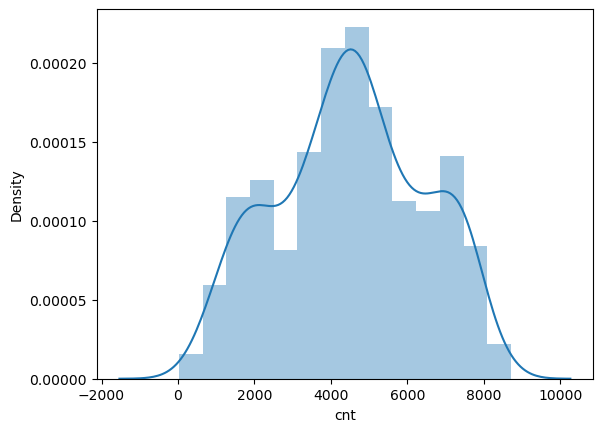

In [83]:
sns.distplot(df['cnt'])
warnings.filterwarnings('ignore')
df['cnt'].describe()

It can be seen from the above plot that on an average, around 4508 bikes are rented, with a standard deviation of 1936.

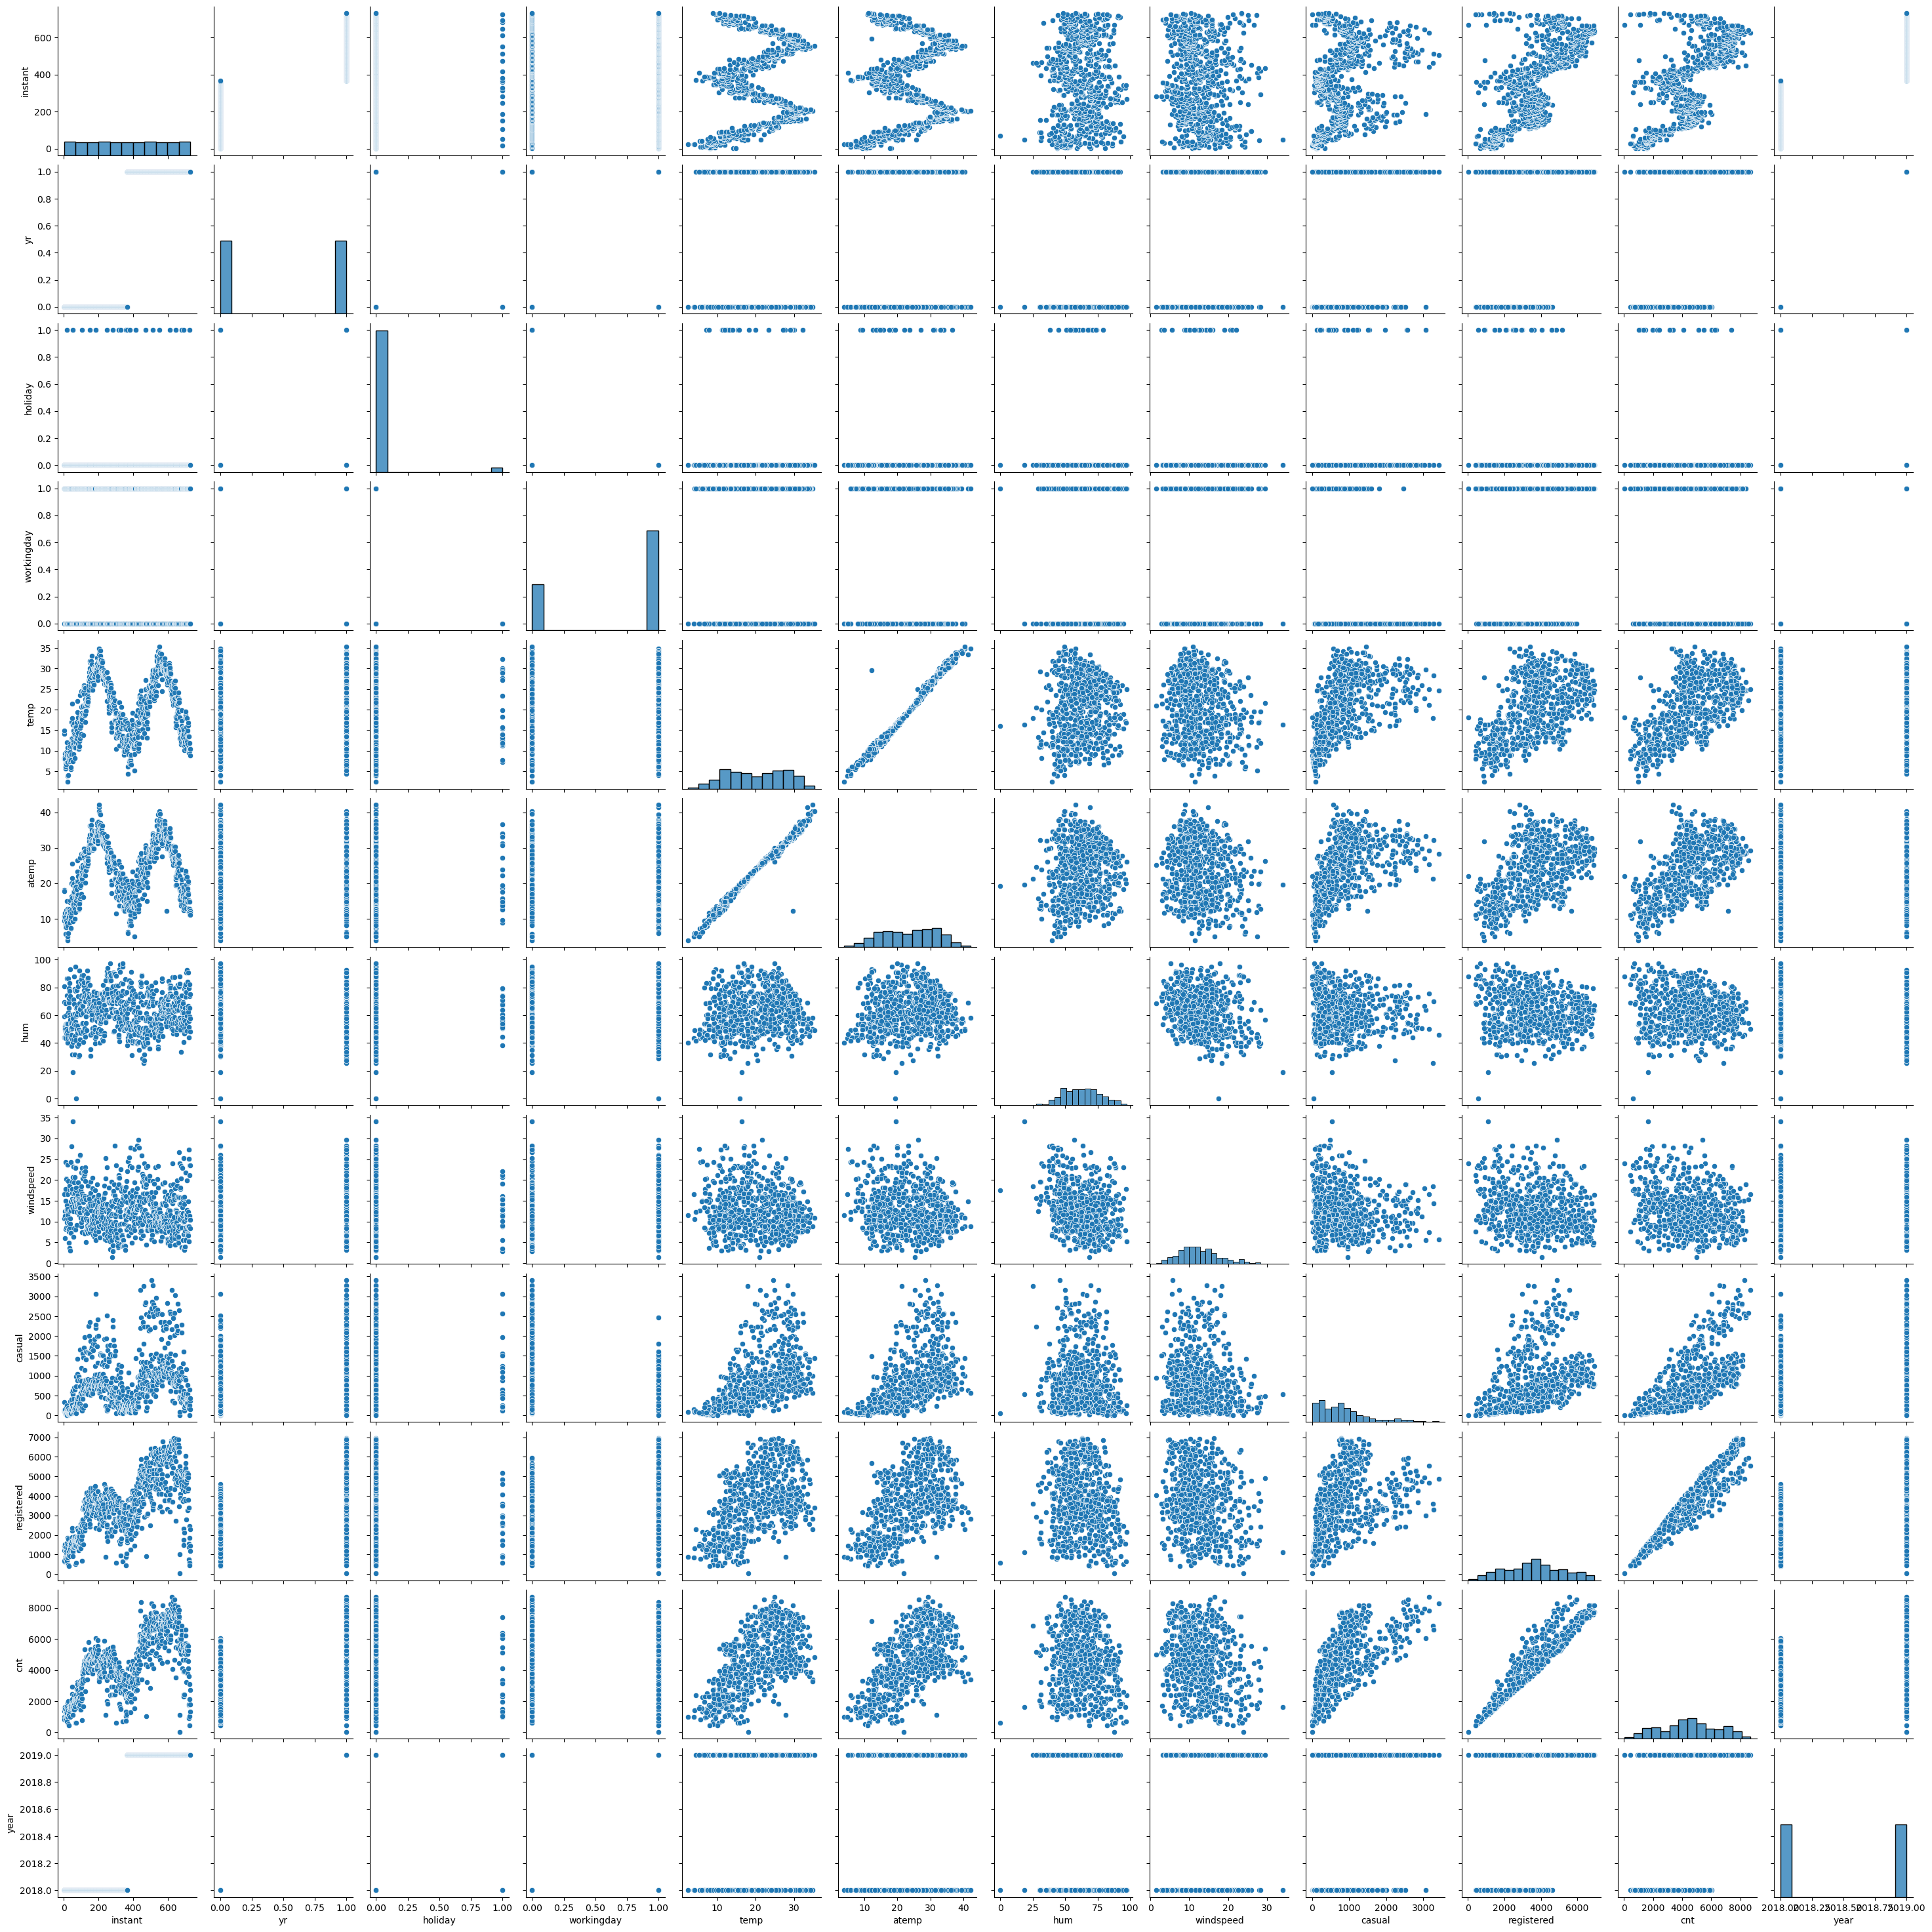

In [84]:
sns.pairplot(df)

It can be seen that temperature and the temperature that is being felt are linearly related to cnt. Humidity and windspeed is lighly negatively related to cnt.

<Axes: xlabel='season', ylabel='cnt'>

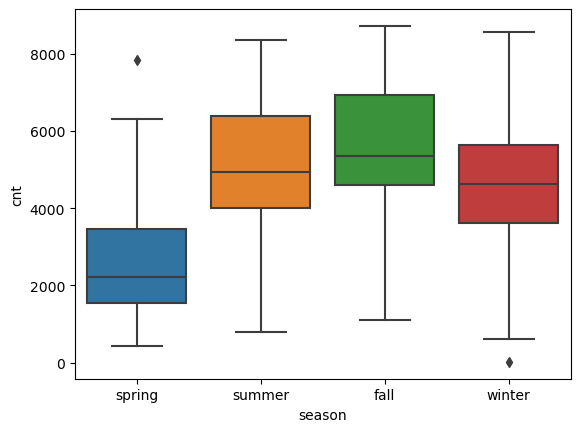

In [85]:
sns.boxplot(df,x='season',y='cnt')

It can be seen that during the spring the counts for bike rental is significantly lower than the other seasons. So it can be predicted that maybe cnt is negatively related to spring.

<Axes: xlabel='year', ylabel='cnt'>

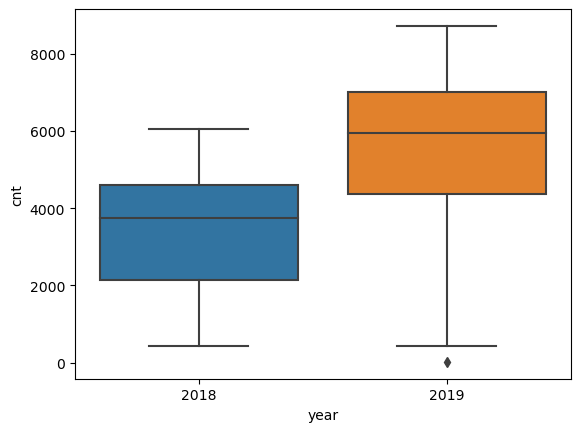

In [86]:
sns.boxplot(df,x='year',y='cnt')

The bike rentals during 2018 were somewhat lower as compared to 2019.

<Axes: xlabel='mnth', ylabel='cnt'>

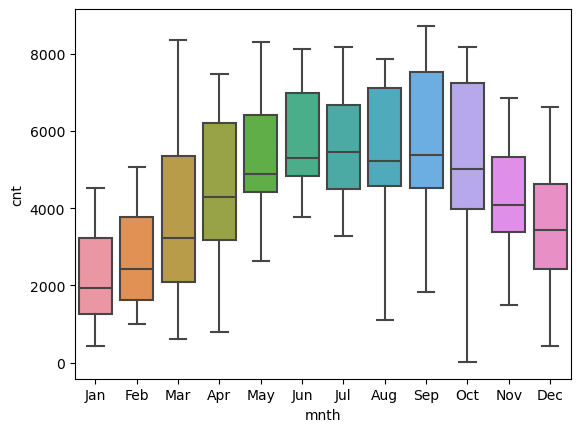

In [87]:
sns.boxplot(df,x='mnth',y='cnt')

It can be seen that from January to September the average value of number of bike rentals increases, after which it goes down.

<Axes: xlabel='Holiday', ylabel='cnt'>

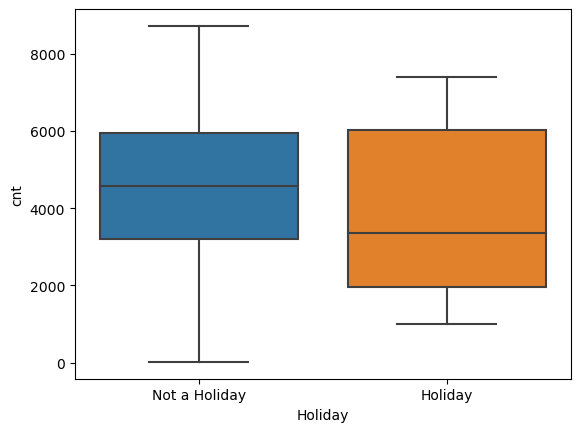

In [88]:
sns.boxplot(df,x='Holiday',y='cnt')

There is a slight increase in the number of rentals on non holidays, but it is very less.

<Axes: xlabel='weathersit', ylabel='cnt'>

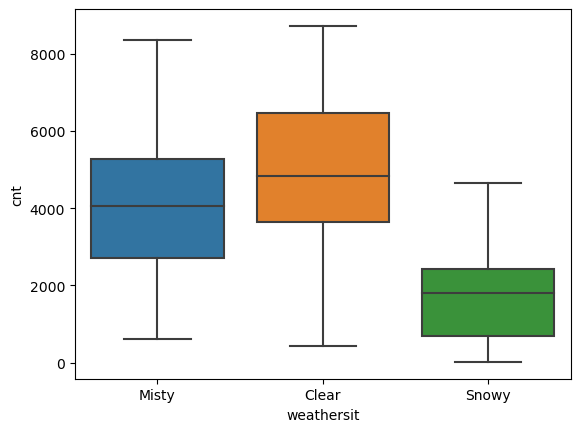

In [89]:
sns.boxplot(df,x='weathersit',y='cnt')

When the weather is snowy, the rentals are lesser, as compared to when the weather is misty or clear.

<Axes: xlabel='weekday', ylabel='cnt'>

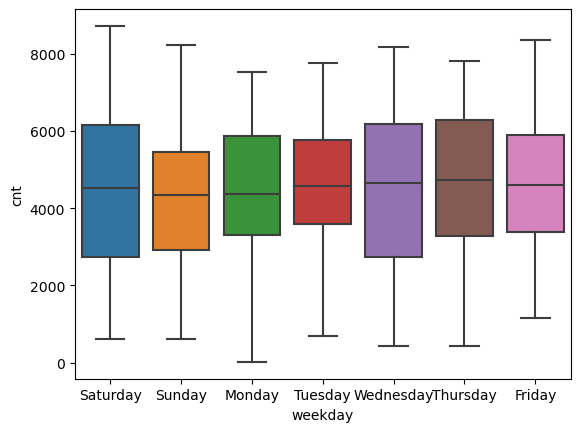

In [90]:
sns.boxplot(df,x='weekday',y='cnt')

<Axes: xlabel='Workingday', ylabel='cnt'>

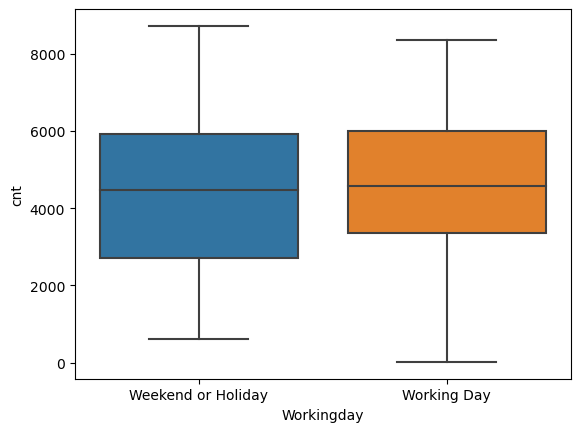

In [91]:
sns.boxplot(df,x='Workingday',y='cnt')

The interquartile range is more spread out on weekends or holidays as compared to working days.

## Model Building and Evaluation
The steps to build a model are:
1. Read, Understand and Visualise the data
2. Prepare the data 
3. Train the model 
4. Residual Analysis
5. Prediction and Evaluation on the test set
The model has been visualised during EDA.
To prepare the data, the categorical variables with 2 values have to be converted to 1 or 0
For other categorical variables, dummy variables are created. It is followed with splitting the data into test data and train data, and then scaling the data. It is followed with deleting the columns which won't be required for model building.

### Data Preparation

In [92]:
# creating dummy variables
status=pd.get_dummies(df[['season','weekday','weathersit','mnth']],drop_first=True)  
df=pd.concat([df,status],axis=1)
df=df.drop(['season','weekday','weathersit','mnth','year','Holiday','Workingday'],axis=1)

In [93]:
df=df.drop(['instant'],axis=1)
df=df.drop(['registered','casual'],axis=1)

In [94]:
df=df.drop(['dteday'],axis=1)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   yr                 730 non-null    int64  
 1   holiday            730 non-null    int64  
 2   workingday         730 non-null    int64  
 3   temp               730 non-null    float64
 4   atemp              730 non-null    float64
 5   hum                730 non-null    float64
 6   windspeed          730 non-null    float64
 7   cnt                730 non-null    int64  
 8   season_spring      730 non-null    uint8  
 9   season_summer      730 non-null    uint8  
 10  season_winter      730 non-null    uint8  
 11  weekday_Monday     730 non-null    uint8  
 12  weekday_Saturday   730 non-null    uint8  
 13  weekday_Sunday     730 non-null    uint8  
 14  weekday_Thursday   730 non-null    uint8  
 15  weekday_Tuesday    730 non-null    uint8  
 16  weekday_Wednesday  730 non

In [96]:
# Train-Test Split
df_train,df_test=train_test_split(df,train_size=0.7,random_state=100)

In [97]:
# Rescaling
scaler=MinMaxScaler()
numval=['atemp','hum','windspeed','cnt','temp']
df_train[numval]=scaler.fit_transform(df_train[numval])

In [98]:
# Step 3: Building the model
y_train=df_train.pop('cnt')
X_train=df_train

In [99]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
y_train.head()

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64

In [101]:
X_train.shape

(510, 29)

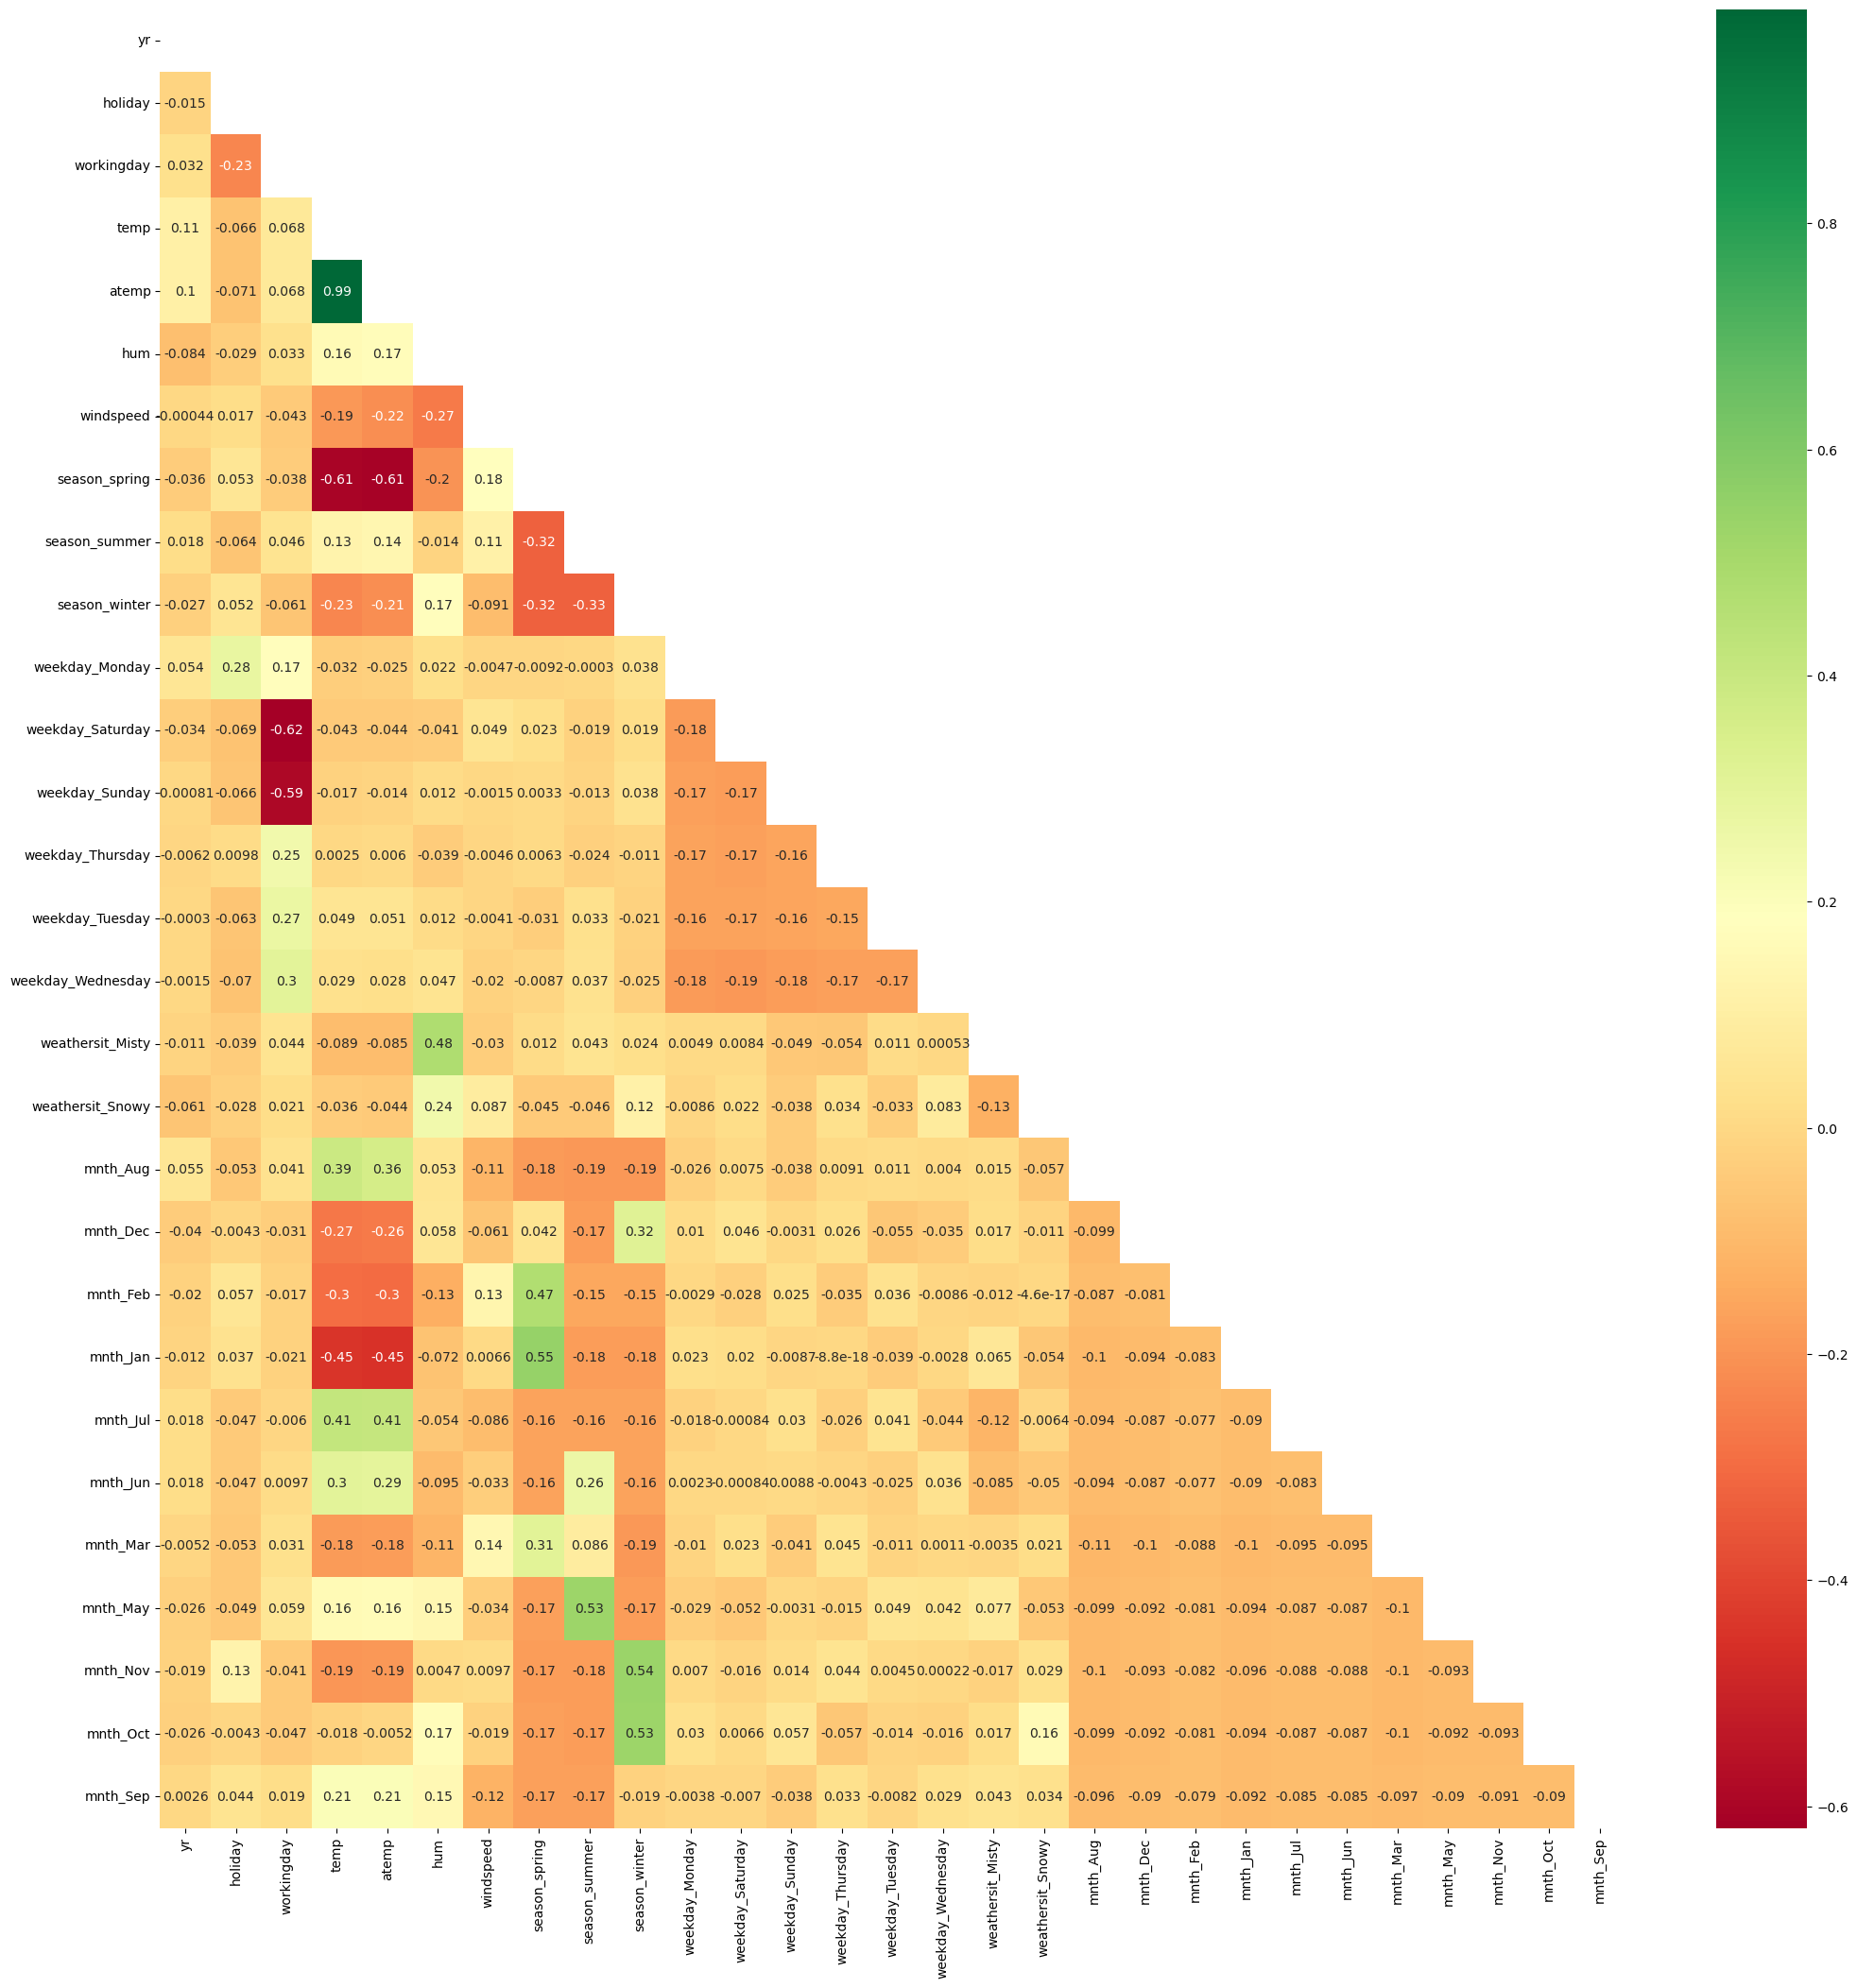

In [102]:
# check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (25,25))
matrix = np.triu(df_train.corr())
sns.heatmap(df_train.corr(), annot = True, cmap="RdYlGn", mask=matrix)
plt.show()

In [103]:
# Model Building- Estimation of predictor variables using RFE
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(estimator=lm,n_features_to_select=15,step=1) # from 29 variables predicting 15 most important predictor variables
rfe=rfe.fit(X_train,y_train)

In [104]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 7),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 4),
 ('season_winter', True, 1),
 ('weekday_Monday', False, 8),
 ('weekday_Saturday', True, 1),
 ('weekday_Sunday', True, 1),
 ('weekday_Thursday', False, 11),
 ('weekday_Tuesday', False, 14),
 ('weekday_Wednesday', False, 12),
 ('weathersit_Misty', True, 1),
 ('weathersit_Snowy', True, 1),
 ('mnth_Aug', False, 13),
 ('mnth_Dec', False, 2),
 ('mnth_Feb', False, 5),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 6),
 ('mnth_Mar', False, 9),
 ('mnth_May', False, 15),
 ('mnth_Nov', False, 3),
 ('mnth_Oct', False, 10),
 ('mnth_Sep', True, 1)]

The recurrent feature estimator picked up the variables for year, holiday, workingday,temperature,humidity, windspeed,spring season, winter season, Saturday , Sunday, Misty weather, Snowy weather, January, July and September

In [105]:
rem=X_train.columns[~rfe.support_] #remaining predictor variables i.e. those predictor variables which were chosesn by RFE

In [106]:
rem

Index(['atemp', 'season_summer', 'weekday_Monday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'mnth_Aug', 'mnth_Dec',
       'mnth_Feb', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct'],
      dtype='object')

In [107]:
# Model - 1
X_train=X_train.drop(rem,axis=1)
X_train_sm=sm.add_constant(X_train) # add constant
mlr=sm.OLS(y_train,X_train_sm)
mlr_model=mlr.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [108]:
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.2
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          9.51e-190
Time:                        10:40:56   Log-Likelihood:                 513.67
No. Observations:                 510   AIC:                            -997.3
Df Residuals:                     495   BIC:                            -933.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2521      0.025      9.930      0.000       0.202       0.302
yr                   0.2317      0.008     28.655      0.000       0.216       0.248
holiday             -0.0052      0.021     -0.246      0.806      -0.047       0.037
workingday           0.0968      0.009     10.442      0.000       0.079       0.115
temp                 0.4596      0.031     14.626      0.000       0.398       0.521
hum                 -0.1434      0.038     -3.822      0.000      -0.217      -0.070
windspeed           -0.1758      0.026     -6.875      0.000      -0.226      -0.126
season_spring       -0.0992      0.015     -6.499      0.000      -0.129      -0.069
season_winter        0.0517      0.012      4.169      0.000       0.027       0.076
weekday_Saturday     0.1068      0.011      9.382      0.000       0.084       0.129
weekday_Sunday       0.0537      0.012      4.494      0.000       0.030       0.077
weathersit_Misty    -0.0577      0.010     -5.513      0.000      -0.078      -0.037
weathersit_Snowy    -0.2525      0.026     -9.613      0.000      -0.304      -0.201
mnth_Jan            -0.0405      0.017     -2.321      0.021      -0.075      -0.006
mnth_Jul            -0.0746      0.017     -4.368      0.000      -0.108      -0.041
mnth_Sep             0.0599      0.015      3.896      0.000       0.030       0.090
==============================================================================
Omnibus:                       62.892   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.883
Skew:                          -0.628   Prob(JB):                     1.91e-35
Kurtosis:                       5.438   Cond. No.                     2.30e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.81e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [109]:
vif

,Features,VIF
2,workingday,41.54
8,weekday_Saturday,10.13
9,weekday_Sunday,9.81
3,temp,3.19
6,season_spring,2.71
1,holiday,2.58
4,hum,1.89
7,season_winter,1.81
10,weathersit_Misty,1.57
12,mnth_Jan,1.55


In [110]:
# based on p-value of holiday, we can remove holiday
X_train2=X_train.drop(['holiday'],axis=1)

In [111]:
X_train2_sm=sm.add_constant(X_train2) # add constant
mlr2=sm.OLS(y_train,X_train2_sm)
mlr2_model=mlr2.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train2.columns
vif['VIF']=[variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [112]:
mlr2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.2
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          9.51e-190
Time:                        10:40:56   Log-Likelihood:                 513.67
No. Observations:                 510   AIC:                            -997.3
Df Residuals:                     495   BIC:                            -933.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2468      0.040      6.180      0.000       0.168       0.325
yr                   0.2317      0.008     28.655      0.000       0.216       0.248
workingday           0.1020      0.026      3.988      0.000       0.052       0.152
temp                 0.4596      0.031     14.626      0.000       0.398       0.521
hum                 -0.1434      0.038     -3.822      0.000      -0.217      -0.070
windspeed           -0.1758      0.026     -6.875      0.000      -0.226      -0.126
season_spring       -0.0992      0.015     -6.499      0.000      -0.129      -0.069
season_winter        0.0517      0.012      4.169      0.000       0.027       0.076
weekday_Saturday     0.1121      0.027      4.146      0.000       0.059       0.165
weekday_Sunday       0.0590      0.027      2.170      0.030       0.006       0.112
weathersit_Misty    -0.0577      0.010     -5.513      0.000      -0.078      -0.037
weathersit_Snowy    -0.2525      0.026     -9.613      0.000      -0.304      -0.201
mnth_Jan            -0.0405      0.017     -2.321      0.021      -0.075      -0.006
mnth_Jul            -0.0746      0.017     -4.368      0.000      -0.108      -0.041
mnth_Sep             0.0599      0.015      3.896      0.000       0.030       0.090
==============================================================================
Omnibus:                       62.892   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.883
Skew:                          -0.628   Prob(JB):                     1.91e-35
Kurtosis:                       5.438   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
vif

,Features,VIF
3,hum,29.73
2,temp,18.11
1,workingday,17.03
7,weekday_Saturday,4.60
4,windspeed,4.55
8,weekday_Sunday,4.47
5,season_spring,3.10
9,weathersit_Misty,2.28
6,season_winter,2.17
0,yr,2.09


In [114]:
# based on vif of humidity , we can remove humidity
X_train3=X_train2.drop(['hum'],axis=1)

In [115]:
X_train3_sm=sm.add_constant(X_train3) # add constant
mlr3=sm.OLS(y_train,X_train3_sm)
mlr3_model=mlr3.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train3.columns
vif['VIF']=[variance_inflation_factor(X_train3.values, i) for i in range(X_train3.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [116]:
mlr3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     200.3
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          8.52e-188
Time:                        10:40:57   Log-Likelihood:                 506.25
No. Observations:                 510   AIC:                            -984.5
Df Residuals:                     496   BIC:                            -925.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1705      0.035      4.863      0.000       0.102       0.239
yr                   0.2352      0.008     28.886      0.000       0.219       0.251
workingday           0.1025      0.026      3.955      0.000       0.052       0.153
temp                 0.4307      0.031     13.931      0.000       0.370       0.491
windspeed           -0.1492      0.025     -5.982      0.000      -0.198      -0.100
season_spring       -0.1020      0.015     -6.602      0.000      -0.132      -0.072
season_winter        0.0426      0.012      3.454      0.001       0.018       0.067
weekday_Saturday     0.1142      0.027      4.170      0.000       0.060       0.168
weekday_Sunday       0.0567      0.028      2.058      0.040       0.003       0.111
weathersit_Misty    -0.0806      0.009     -9.294      0.000      -0.098      -0.064
weathersit_Snowy    -0.2921      0.024    -11.939      0.000      -0.340      -0.244
mnth_Jan            -0.0442      0.018     -2.501      0.013      -0.079      -0.009
mnth_Jul            -0.0675      0.017     -3.919      0.000      -0.101      -0.034
mnth_Sep             0.0569      0.016      3.653      0.000       0.026       0.087
==============================================================================
Omnibus:                       65.698   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.520
Skew:                          -0.658   Prob(JB):                     1.14e-36
Kurtosis:                       5.461   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
vif

,Features,VIF
1,workingday,13.48
2,temp,12.77
3,windspeed,4.52
6,weekday_Saturday,3.85
7,weekday_Sunday,3.61
4,season_spring,2.85
0,yr,2.07
5,season_winter,1.78
10,mnth_Jan,1.65
8,weathersit_Misty,1.59


In [118]:
# working day and weekday_ Sunday are related to each other.Thus to solve the vif of working day, remove weekday_Sunday
X_train4=X_train3.drop(['weekday_Sunday'],axis=1)

In [119]:
X_train4_sm=sm.add_constant(X_train4) # add constant
mlr4=sm.OLS(y_train,X_train4_sm)
mlr4_model=mlr4.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train4.columns
vif['VIF']=[variance_inflation_factor(X_train4.values, i) for i in range(X_train4.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [120]:
mlr4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     215.3
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          4.64e-188
Time:                        10:40:59   Log-Likelihood:                 504.08
No. Observations:                 510   AIC:                            -982.2
Df Residuals:                     497   BIC:                            -927.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2195      0.026      8.503      0.000       0.169       0.270
yr                   0.2354      0.008     28.818      0.000       0.219       0.251
workingday           0.0543      0.011      4.897      0.000       0.033       0.076
temp                 0.4305      0.031     13.881      0.000       0.370       0.491
windspeed           -0.1501      0.025     -6.000      0.000      -0.199      -0.101
season_spring       -0.1032      0.015     -6.660      0.000      -0.134      -0.073
season_winter        0.0415      0.012      3.354      0.001       0.017       0.066
weekday_Saturday     0.0660      0.014      4.630      0.000       0.038       0.094
weathersit_Misty    -0.0801      0.009     -9.207      0.000      -0.097      -0.063
weathersit_Snowy    -0.2909      0.025    -11.856      0.000      -0.339      -0.243
mnth_Jan            -0.0448      0.018     -2.527      0.012      -0.080      -0.010
mnth_Jul            -0.0665      0.017     -3.854      0.000      -0.100      -0.033
mnth_Sep             0.0548      0.016      3.516      0.000       0.024       0.085
==============================================================================
Omnibus:                       71.549   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.447
Skew:                          -0.700   Prob(JB):                     1.20e-41
Kurtosis:                       5.628   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
vif

,Features,VIF
2,temp,6.62
1,workingday,4.51
3,windspeed,4.13
4,season_spring,2.36
0,yr,2.07
6,weekday_Saturday,1.80
9,mnth_Jan,1.61
7,weathersit_Misty,1.56
5,season_winter,1.44
10,mnth_Jul,1.37


In [122]:
# since windspeed is related to temperature, we remove windspeed
X_train5=X_train4.drop(['windspeed'],axis=1)

In [123]:
X_train5_sm=sm.add_constant(X_train5) # add constant
mlr5=sm.OLS(y_train,X_train5_sm)
mlr5_model=mlr5.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train5.columns
vif['VIF']=[variance_inflation_factor(X_train5.values, i) for i in range(X_train5.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [124]:
mlr5_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     216.4
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          1.01e-181
Time:                        10:41:00   Log-Likelihood:                 486.25
No. Observations:                 510   AIC:                            -948.5
Df Residuals:                     498   BIC:                            -897.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1532      0.024      6.348      0.000       0.106       0.201
yr                   0.2339      0.008     27.697      0.000       0.217       0.251
workingday           0.0554      0.011      4.830      0.000       0.033       0.078
temp                 0.4573      0.032     14.404      0.000       0.395       0.520
season_spring       -0.1064      0.016     -6.642      0.000      -0.138      -0.075
season_winter        0.0519      0.013      4.098      0.000       0.027       0.077
weekday_Saturday     0.0639      0.015      4.333      0.000       0.035       0.093
weathersit_Misty    -0.0788      0.009     -8.759      0.000      -0.096      -0.061
weathersit_Snowy    -0.3050      0.025    -12.068      0.000      -0.355      -0.255
mnth_Jan            -0.0299      0.018     -1.647      0.100      -0.066       0.006
mnth_Jul            -0.0634      0.018     -3.552      0.000      -0.099      -0.028
mnth_Sep             0.0629      0.016      3.916      0.000       0.031       0.095
==============================================================================
Omnibus:                       77.495   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.069
Skew:                          -0.728   Prob(JB):                     3.64e-49
Kurtosis:                       5.895   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
vif

,Features,VIF
2,temp,5.58
1,workingday,4.40
0,yr,2.06
3,season_spring,2.00
5,weekday_Saturday,1.76
8,mnth_Jan,1.61
6,weathersit_Misty,1.55
4,season_winter,1.40
9,mnth_Jul,1.35
10,mnth_Sep,1.18


In [126]:
# To resolve the p-value of January, we remove mnth_Jan
X_train6=X_train5.drop(['mnth_Jan'],axis=1)

In [127]:
X_train6_sm=sm.add_constant(X_train6) # add constant
mlr6=sm.OLS(y_train,X_train6_sm)
mlr6_model=mlr6.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train6.columns
vif['VIF']=[variance_inflation_factor(X_train6.values, i) for i in range(X_train6.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [128]:
mlr6_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     236.9
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          2.47e-182
Time:                        10:41:04   Log-Likelihood:                 484.87
No. Observations:                 510   AIC:                            -947.7
Df Residuals:                     499   BIC:                            -901.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1461      0.024      6.142      0.000       0.099       0.193
yr                   0.2335      0.008     27.609      0.000       0.217       0.250
workingday           0.0552      0.011      4.810      0.000       0.033       0.078
temp                 0.4691      0.031     15.138      0.000       0.408       0.530
season_spring       -0.1130      0.016     -7.280      0.000      -0.144      -0.083
season_winter        0.0543      0.013      4.314      0.000       0.030       0.079
weekday_Saturday     0.0637      0.015      4.314      0.000       0.035       0.093
weathersit_Misty    -0.0795      0.009     -8.834      0.000      -0.097      -0.062
weathersit_Snowy    -0.3035      0.025    -11.995      0.000      -0.353      -0.254
mnth_Jul            -0.0660      0.018     -3.705      0.000      -0.101      -0.031
mnth_Sep             0.0619      0.016      3.849      0.000       0.030       0.094
==============================================================================
Omnibus:                       75.344   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.607
Skew:                          -0.706   Prob(JB):                     5.59e-48
Kurtosis:                       5.872   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
vif

,Features,VIF
2,temp,5.47
1,workingday,4.37
0,yr,2.05
5,weekday_Saturday,1.75
6,weathersit_Misty,1.54
3,season_spring,1.50
4,season_winter,1.40
8,mnth_Jul,1.35
9,mnth_Sep,1.18
7,weathersit_Snowy,1.07


In [130]:
# To resolve the vif of temp, we remove mnth_Jul
X_train7=X_train6.drop(['mnth_Jul'],axis=1)

In [131]:
X_train7_sm=sm.add_constant(X_train7) # add constant
mlr7=sm.OLS(y_train,X_train7_sm)
mlr7_model=mlr7.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train7.columns
vif['VIF']=[variance_inflation_factor(X_train7.values, i) for i in range(X_train7.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [132]:
mlr7_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     255.2
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          1.28e-180
Time:                        10:41:06   Log-Likelihood:                 477.94
No. Observations:                 510   AIC:                            -935.9
Df Residuals:                     500   BIC:                            -893.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1607      0.024      6.767      0.000       0.114       0.207
yr                   0.2346      0.009     27.418      0.000       0.218       0.251
workingday           0.0565      0.012      4.860      0.000       0.034       0.079
temp                 0.4287      0.029     14.594      0.000       0.371       0.486
season_spring       -0.1179      0.016     -7.525      0.000      -0.149      -0.087
season_winter        0.0548      0.013      4.296      0.000       0.030       0.080
weekday_Saturday     0.0639      0.015      4.273      0.000       0.035       0.093
weathersit_Misty    -0.0773      0.009     -8.500      0.000      -0.095      -0.059
weathersit_Snowy    -0.3051      0.026    -11.912      0.000      -0.355      -0.255
mnth_Sep             0.0729      0.016      4.553      0.000       0.041       0.104
==============================================================================
Omnibus:                       75.989   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.274
Skew:                          -0.722   Prob(JB):                     4.88e-47
Kurtosis:                       5.820   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
vif

,Features,VIF
2,temp,4.61
1,workingday,4.33
0,yr,2.05
5,weekday_Saturday,1.74
6,weathersit_Misty,1.53
3,season_spring,1.49
4,season_winter,1.37
8,mnth_Sep,1.15
7,weathersit_Snowy,1.07


In [134]:
# To further simplify the model, remove weekday_Saturday
X_train8=X_train7.drop(['weekday_Saturday'],axis=1)

In [135]:
X_train8_sm=sm.add_constant(X_train8) # add constant
mlr8=sm.OLS(y_train,X_train8_sm)
mlr8_model=mlr8.fit()
#VIF
vif=pd.DataFrame()
vif['Features']=X_train8.columns
vif['VIF']=[variance_inflation_factor(X_train8.values, i) for i in range(X_train8.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)

In [136]:
mlr8_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     275.4
Date:                Wed, 20 Sep 2023   Prob (F-statistic):          5.70e-178
Time:                        10:41:08   Log-Likelihood:                 468.80
No. Observations:                 510   AIC:                            -919.6
Df Residuals:                     501   BIC:                            -881.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1924      0.023      8.382      0.000       0.147       0.237
yr                   0.2341      0.009     26.901      0.000       0.217       0.251
workingday           0.0257      0.009      2.769      0.006       0.007       0.044
temp                 0.4273      0.030     14.302      0.000       0.369       0.486
season_spring       -0.1189      0.016     -7.466      0.000      -0.150      -0.088
season_winter        0.0529      0.013      4.082      0.000       0.027       0.078
weathersit_Misty    -0.0754      0.009     -8.155      0.000      -0.094      -0.057
weathersit_Snowy    -0.2994      0.026    -11.507      0.000      -0.350      -0.248
mnth_Sep             0.0730      0.016      4.481      0.000       0.041       0.105
==============================================================================
Omnibus:                       63.499   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.746
Skew:                          -0.595   Prob(JB):                     3.42e-40
Kurtosis:                       5.671   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
vif

,Features,VIF
2,temp,3.46
1,workingday,2.92
0,yr,2.05
5,weathersit_Misty,1.51
3,season_spring,1.32
4,season_winter,1.31
7,mnth_Sep,1.15
6,weathersit_Snowy,1.07


The above model can be a good representation of the bike rental count since:
1. Multicolinearity is resolved : all vif is less than 5
2. p-value of all predictor variables is less than 0.05 i.e can reject H0 ( corresponding variable does not impact the dependent variable)
3. F-statistic and the corresponding p-value: F-statistic is very high and corresponding p-value is almost 0 which indicates that the model is significant

In [138]:
# The parameters of the predictor variables:
mlr8_model.params

const               0.192367
yr                  0.234097
workingday          0.025677
temp                0.427319
season_spring      -0.118914
season_winter       0.052924
weathersit_Misty   -0.075353
weathersit_Snowy   -0.299369
mnth_Sep            0.072966
dtype: float64

Thus the model is :
cnt=0.234097*yr+0.025677*workingday+0.427319*temp-0.118914*season_spring+0.052924*season_winter-0.075353*weathersit_Misty-0.299369*weathersit_Snowy+0.072966*mnth_Sep

Text(0.5, 0, 'Errors')

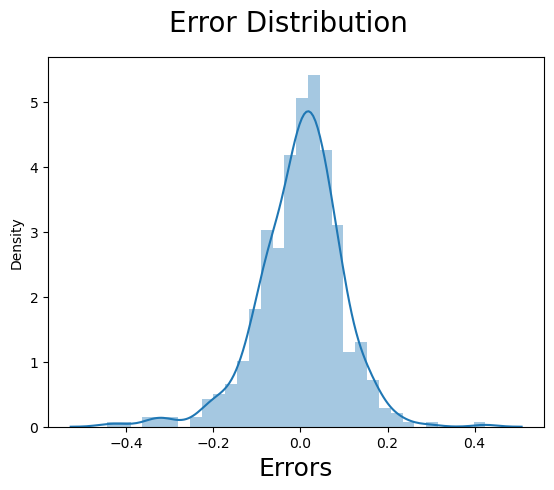

In [139]:
# Step 4: Residual Analysis
y_train_pred=mlr8_model.predict(X_train8_sm)
res=y_train-y_train_pred
fig=plt.figure()
sns.distplot(res)
fig.suptitle('Error Distribution', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)

The above error distribution follows a normal(approx) distribution and hence the above model is acceptable.

In [140]:
# Step 6: Model Evaluation
# Rescaling the test data
numval=['atemp','hum','windspeed','cnt','temp']
df_test[numval]=scaler.transform(df_test[numval])

In [141]:
# Preparing X and y for test data
pred=X_train8.columns
y_test=df_test.pop('cnt')
X_test=df_test[pred]

In [142]:
#calculating the y values for test data 
X_test_sm=sm.add_constant(X_test)
y_test_pred=mlr8_model.predict(X_test_sm)
X_test.head()

,yr,workingday,temp,season_spring,season_winter,weathersit_Misty,weathersit_Snowy,mnth_Sep
184,0,0,0.831783,0,0,1,0,0
535,1,1,0.901354,0,0,0,0,0
299,0,1,0.511964,0,1,1,0,0
221,0,1,0.881625,0,0,0,0,0
152,0,1,0.817246,0,0,0,0,0


In [150]:
#Evaluating based on Mean Squared Error
mse1 = mean_squared_error(y_test, y_test_pred)

In [152]:
mse1

0.009190736758322382

Mean squared error of 0.009 indicates that sum of errors at each point adds upto less than 1% , while comparing the actual values and the predicted values using model 8. 

Text(0.5, 0.98, 'Actual and Predicted')

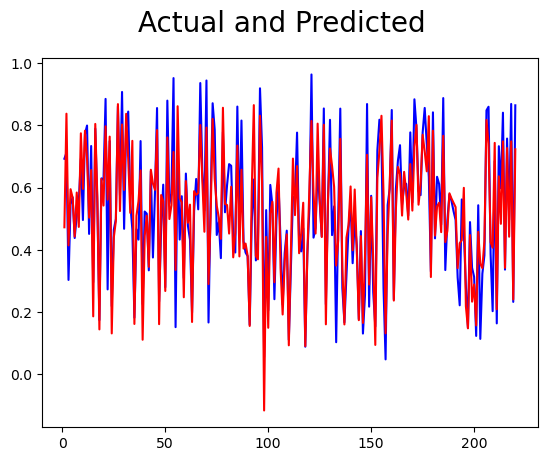

In [153]:
#actual and predicted values of the test data as shown visually
c = [i for i in range(1,221,1)] # generating index
fig = plt.figure()
plt.plot(c,y_test, color="blue", linewidth=1.5, linestyle="-")
plt.plot(c,y_test_pred, color="red", linewidth=1.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)

Text(0, 0.5, 'ytest-ypred')

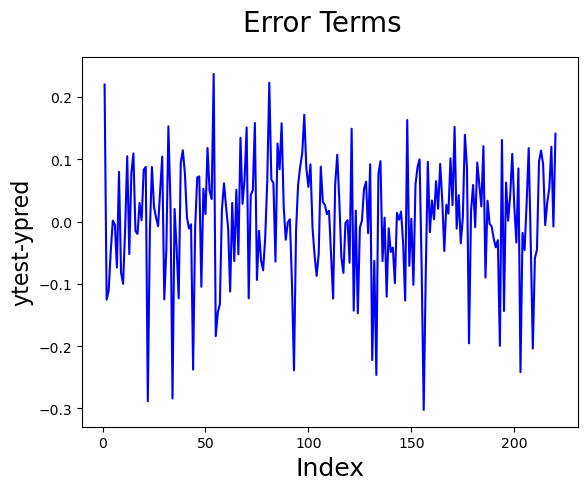

In [154]:
# Error terms for y test
c = [i for i in range(1,221,1)]
fig = plt.figure()
plt.plot(c,y_test-y_test_pred, color="blue", linewidth=1.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('ytest-ypred', fontsize=16)

It can be seen that the error for test data is centered around 0 and is peaky as some points.

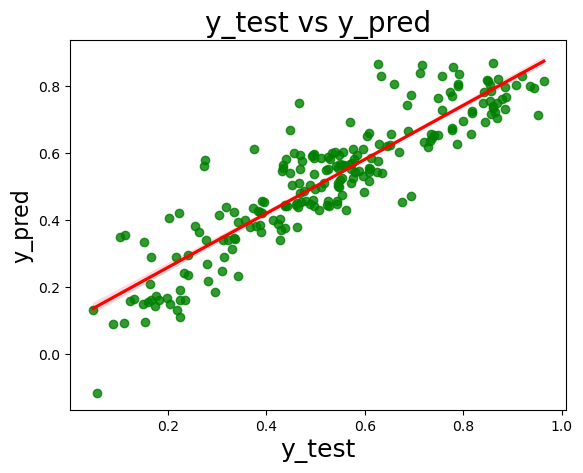

In [155]:
# ytest vs ypredicted in comparison to y=x line
sns.regplot(x=y_test, y=y_test_pred, ci=68, fit_reg=True,scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()
#The plot below also proves homoscedacity

In [156]:
# R^2 value for test data
r2_test=r2_score(y_true=y_test,y_pred=y_test_pred)
print(r2_test)

0.8077825943840156


In [160]:
# R^2 value for test data
r2_train=r2_score(y_true=y_train,y_pred=y_train_pred)
print(r2_train)

0.8147172355659899


calculating the adjusted R^2 value for test and train data since it incorporates the number of predictor varaibles as well

In [161]:
# Calculating Adjusted-R^2 value for the test dataset

adjusted_r2_test = round(1-(1-r2_test)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adjusted_r2_test)

0.8005


In [162]:
# Calculating Adjusted-R^2 value for the train dataset

adjusted_r2_train = round(1-(1-r2_train)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1),4)
print(adjusted_r2_train)

0.8091


Thus the model which is developed can explain the 80.05% variance in train data and 80.91% variace in test data.
The model is such that the demand of bikes depends up on : Temperature on that day, if the weather situation on that day is snowy or not,it depends on the year we are analysing, if the season is spring or not, if the weather situation is misty or not, if the month is september,if the season is winter and if it is a working day.


Model predictor parameters(8 nos.): 'yr','workingday','temp','season_spring','season_winter','weathersit_Misty', weathersit_Snowy', 'mnth_Sep'
Parameters with respect to the .csv file provided(6 nos.): year, working day, temperature, season, weather situation and month.

In [ ]:
mlr8_model.params